In [21]:
#Cargar librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math

Text(0.5, 1.0, 'Fuga en relación a la osmolardiad de POPG')

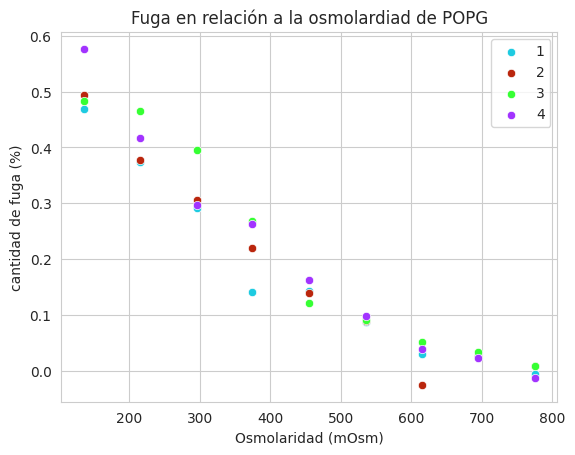

In [22]:
#Cargar los datos y graficarlos
sns.set_style('whitegrid')

__Fpath__="../../"
url ="/content/popgpuro.csv"

file = __Fpath__+url

df = pd.read_csv(file, header=0, delimiter=";", decimal=',', on_bad_lines='skip')

dfp = pd.DataFrame(df)
dfp = dfp.apply(pd.to_numeric)
dfp.head(5)

sns.scatterplot(data=dfp, x="osmolaridad", y="toma1",
                color="#1ECBE1", label="1")
sns.scatterplot(data=dfp, x="osmolaridad", y="toma2",
                color="#BA260D", label="2")
sns.scatterplot(data=dfp, x="osmolaridad", y="toma3",
                color="#36FF33", label="3")
sns.scatterplot(data=dfp, x="osmolaridad", y="toma4",
                color="#A233FF", label="4")

plt.xlabel('Osmolaridad (mOsm)')
plt.ylabel('cantidad de fuga (%)')
plt.title('Fuga en relación a la osmolardiad de POPG')


0   -0.000679
1    0.026371
2    0.023572
3    0.091586
4    0.141439
5    0.223146
6    0.322054
7    0.408227
8    0.505862
dtype: float64
0    0.010351
1    0.004468
2    0.033895
3    0.004786
4    0.016728
5    0.058836
6    0.048538
7    0.042809
8    0.048088
dtype: float64


Text(0.5, 1.0, 'Fuga en relación a la osmolardiad de POPG')

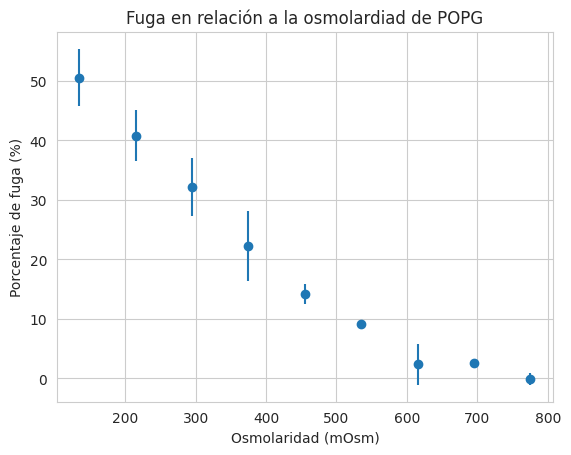

In [23]:
#Obtener el promedio, la desviación estandar y graficar con barras de error

promedio = dfp.iloc[:, 1:].mean(axis=1)
desviacion_estandar = dfp.iloc[:, 1:].apply(lambda row: row.std(), axis=1)

print(promedio)
print(desviacion_estandar)

x = dfp.iloc[:, 0]
plt.errorbar(x, promedio*100, yerr=desviacion_estandar*100, xerr=desviacion_estandar, fmt='o', label='Barras de error')

plt.xlabel('Osmolaridad (mOsm)')
plt.ylabel('Porcentaje de fuga (%)')
plt.title('Fuga en relación a la osmolardiad de POPG')


Text(0.5, 1.0, 'Ajuste lineal de los resultados')

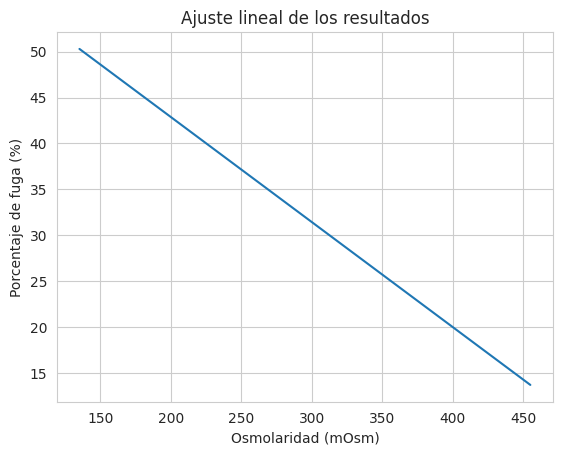

In [37]:
#Tomar la parte lineal de los datos y hacer un ajuste tipo regresion lineal (Modelo monodisperso)
y_lin = promedio[4:9]
x_lin = np.array(x[4:9]).reshape(-1,1)


reg = LinearRegression().fit(x_lin, y_lin) #Se hace un ajuste lineal de los datos
y_pred = reg.predict(x_lin)

c_sol = reg.predict(np.array(0).reshape(-1,1)) #Predice el valor de fuga para C_sol=0 que se utiliza como punto de referncia

m = reg.coef_[0] #Obtener la pendiente del ajuste
b = reg.intercept_ #Obtener la intersección

def calc_x(F): #Realizar una función F=mx+b para obtener el porcentaje de fuga en relación de la osmolaridad
  x = (F - b)/m
  return x

c_sol_star = calc_x(0) #Con base en la función se obtiene C_sol^* que es F=0, es decir el punto donde empieza la fuga
c_sol = calc_x(1) # Igualmente, con la función se obtiene C_sol en su máximo de fuga que es F=1

#Obtener el limite de elasticidad que se representa con la pendiente, ya que como se explica en el documento, la deformación se relaciona con el cambio de fuga en relación a la concentración diluida
epsilon_star = m

plt.plot(x_lin, y_pred*100)
plt.xlabel('Osmolaridad (mOsm)')
plt.ylabel('Porcentaje de fuga (%)')
plt.title('Ajuste lineal de los resultados')

Text(0.5, 1.0, 'Porcentaje de fuga en relación a la osmolardiad de POPG')

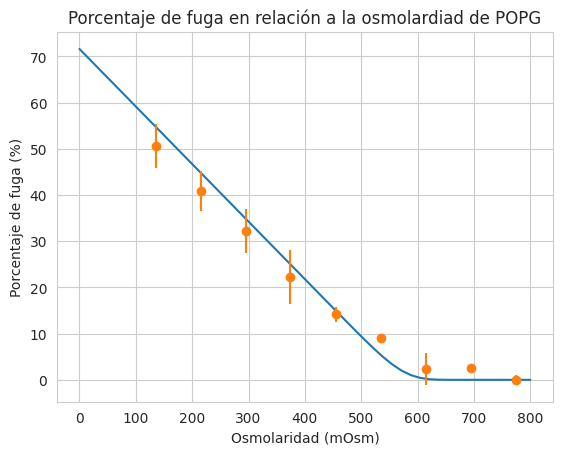

In [39]:
#Teniendo en cuenta los datos obtenidos en la distribución de tamaños realizar el ajuste para la polidispersión
r_hat = 93.75 #Radio promedio obtenido en la distribución
m = 66 #Ancho de la distribución

# Despejando (K) la formula para %F=100 con c_sol (en el documento se muestra como la ecuación 3.17)
K = (-c_sol * (1+epsilon_star)*r_hat*(m + 3)) / (epsilon_star * (m + 1))
# Utilizando la formula para %F=0 con c_sol^* (en el documento se muestra como la ecuación 3.18)
C_star = c_sol_star + (K*epsilon_star*(m+1))/((1+epsilon_star)*r_hat*(m+3))
#Concentración inicial donde no hay estrés osmótico
C_0 = 800

def F(c_sol): #Se define una función para cada concentración externa en ese momento (como se explica en el documento)
  y = ((K * epsilon_star * (m+1))/((1 + epsilon_star)*(C_star - c_sol)*r_hat)) #Utilizar la expresión para y (en el documento se muestra como la ecuación 3.15)
  x = (100*((1+epsilon_star)**3)*(C_star - c_sol))/(C_0) #Utilizar la expresión para x (en el documento se muestra como la ecuación 3.16)

  D = 0  #Implementar la sumatoria que define la función para el porcentaje de fuga (en el documento se muestra como la ecuación 3.14)
  for i in range(m + 2):
    D += ((m + 3 - i)/(m + 3))* ((y**i)/(math.factorial(i)))
  return x * np.exp(-y) * D

#Crear una lista para guardar los valores obtenidos para el porcentaje de fuga para cada osmolaridad externa
x_def = np.linspace(0, 800)
y_def = []
for i in (x_def): #Recorre los valores de osmolaridad y los asocia con el porcentaje de fuga calculado con F
  y_def.append(F(i))

#Graficar los datos
plt.plot(x_def, y_def)
plt.errorbar(x, promedio*100, yerr=desviacion_estandar*100, xerr=desviacion_estandar, fmt='o', label='Barras de error')
plt.xlabel('Osmolaridad (mOsm)')
plt.ylabel('Porcentaje de fuga (%)')
plt.title('Porcentaje de fuga en relación a la osmolardiad de POPG')



In [32]:
print(f"K={K}, epsilon_star={epsilon_star}, C_star={C_star}, c_sol={c_sol}, r_hat={r_hat}")

K=-25246189.239429433, epsilon_star=-0.0011437370591909878, C_star=874.3268323467119, c_sol=-299.41493889416245, r_hat=93.75


In [33]:
#Calcular la tensión teniendo en cuenta el modulo de young y el limite de elasticidad.

K_u = 25246189.239429433/1000 #Osm
epsilon_star_u = 0.0011437370591909878/1000 #Osm

k= (K_u * 8.314 * 310.15)/(4 * 3.681) #Se obtiene el modulo de young a partir de K
tension= k*epsilon_star_u

print(tension)

5.056826153183187
